Kaggle dataset page: https://www.kaggle.com/kwadwoofosu/predict-test-scores-of-students

 # I. Problem Framing

### a. Business Objective
From this project, we hope to find the factors that affect students' performance the most.

### b. Output
The goal is to predict students' performance (judged by their post-test score) based on the learning environment that they are in. We also want to optimize the learning environments so it can increase students' ability to study.

### c. What machine learning task?
We are using supervised learning, specifically regression. We are going to predict the post-test score as the label, which we already have from the available dataset, so we are using supervised learning. As the label is continuous numerical feature, we are going to be using regression.

### d. Performance Measure
We can use R-squared to measure our model's goodness of fit and RMSE to measure how much error the model predicts.

### e. Risks
Risks when our model produces wrong prediction can be development in the wrong categories. For example if our model predicts that school setting has a high impact on students' performance, it could lead to future schools being built in only certain areas when in fact it does not have any impact on the performance. It could in turn affect future students because they may have to commute longer to their schools.

# II. EDA

In [1]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load the dataset
df_school = pd.read_csv('test_scores.csv')

In [3]:
df_school.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2133 entries, 0 to 2132
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   school           2133 non-null   object 
 1   school_setting   2133 non-null   object 
 2   school_type      2133 non-null   object 
 3   classroom        2133 non-null   object 
 4   teaching_method  2133 non-null   object 
 5   n_student        2133 non-null   float64
 6   student_id       2133 non-null   object 
 7   gender           2133 non-null   object 
 8   lunch            2133 non-null   object 
 9   pretest          2133 non-null   float64
 10  posttest         2133 non-null   float64
dtypes: float64(3), object(8)
memory usage: 183.4+ KB


There are no null values

In [4]:
df_school.head()

,school,school_setting,school_type,classroom,teaching_method,n_student,student_id,gender,lunch,pretest,posttest
0,ANKYI,Urban,Non-public,6OL,Standard,20.0,2FHT3,Female,Does not qualify,62.0,72.0
1,ANKYI,Urban,Non-public,6OL,Standard,20.0,3JIVH,Female,Does not qualify,66.0,79.0
2,ANKYI,Urban,Non-public,6OL,Standard,20.0,3XOWE,Male,Does not qualify,64.0,76.0
3,ANKYI,Urban,Non-public,6OL,Standard,20.0,556O0,Female,Does not qualify,61.0,77.0
4,ANKYI,Urban,Non-public,6OL,Standard,20.0,74LOE,Male,Does not qualify,64.0,76.0


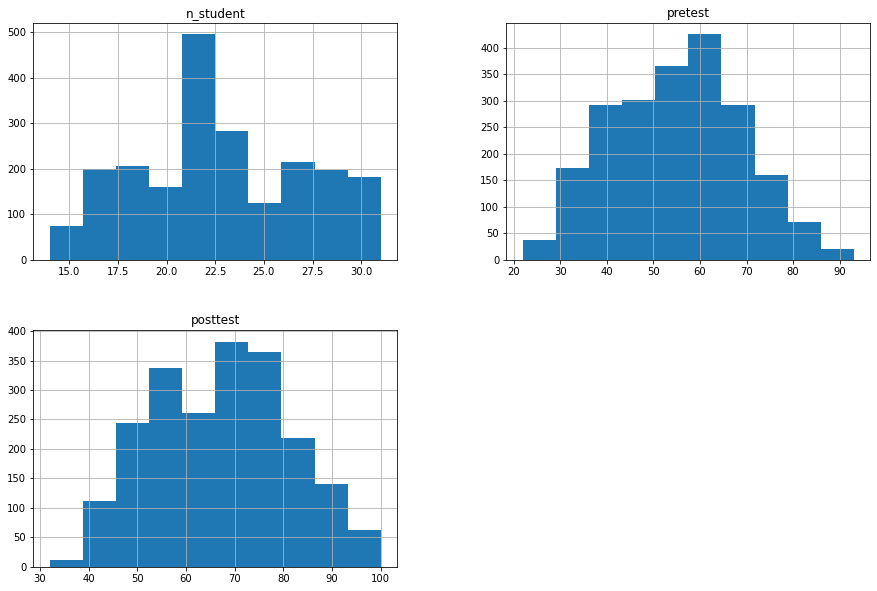

In [5]:
df_school.hist(figsize=(15,10));

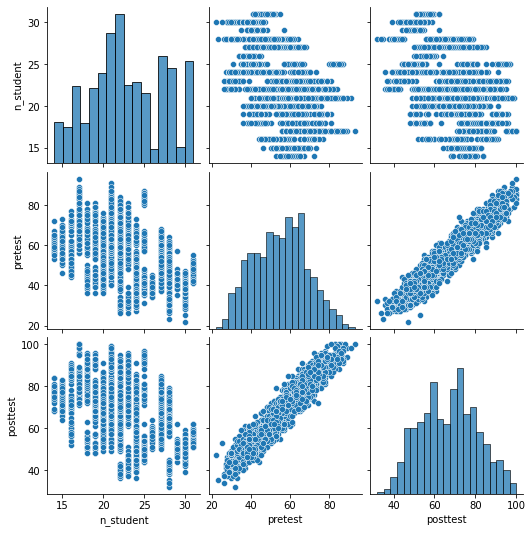

In [165]:
sns.pairplot(df_school);

Students' pretest score have a high correlation with their post-test scores, so it is important to use it as a feature when training the model.

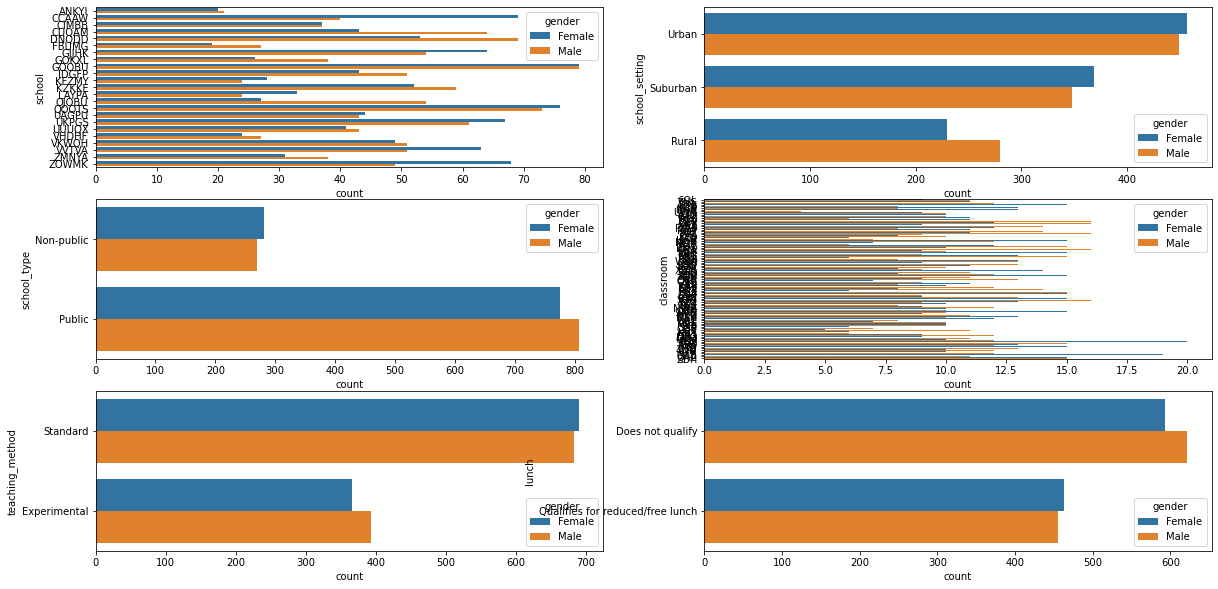

In [6]:
fig, axes = plt.subplots(3, 2, figsize=(20,10))
for ix, var in enumerate(['school', 'school_setting', 'school_type', 'classroom', 'teaching_method', 'lunch']):
    sns.countplot(y=var, hue='gender', data=df_school, ax=axes.flatten()[ix])

At a glance, the data is not evenly distributed for school_type and teaching method, so we do train test split while stratifying these features.

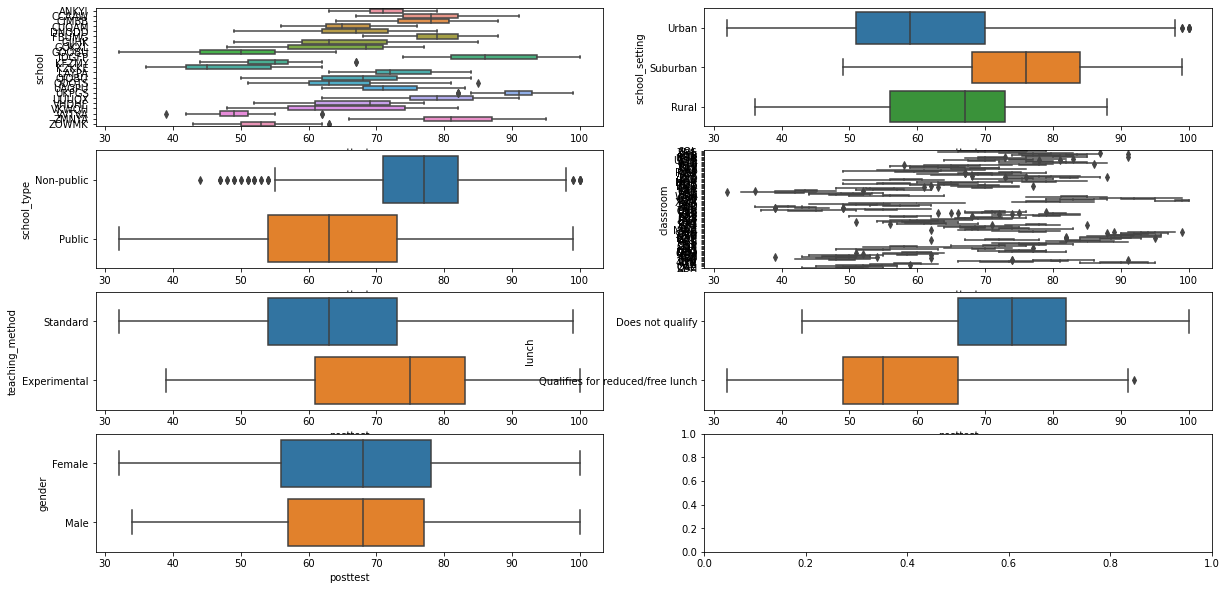

In [177]:
fig, axes = plt.subplots(4, 2, figsize=(20,10))
for ix, var in enumerate(['school', 'school_setting', 'school_type', 'classroom', 'teaching_method', 'lunch', 'gender']):
    sns.boxplot(x='posttest', y=var, data=df_school, ax=axes.flatten()[ix])

In [7]:
# train test split
from sklearn.model_selection import train_test_split

df_school_train, df_school_test = train_test_split(df_school, test_size=0.2, random_state=10, stratify=df_school[['school_type', 'teaching_method']])

In [8]:
df_school_train.head()

,school,school_setting,school_type,classroom,teaching_method,n_student,student_id,gender,lunch,pretest,posttest
1355,QOQTS,Urban,Public,X2O,Experimental,25.0,SAYN0,Female,Does not qualify,62.0,76.0
1731,VHDHF,Rural,Non-public,KR1,Experimental,15.0,UV4VL,Male,Qualifies for reduced/free lunch,53.0,68.0
1311,QOQTS,Urban,Public,SUR,Standard,28.0,6B3YQ,Female,Does not qualify,55.0,64.0
1225,OJOBU,Rural,Public,XJ8,Standard,23.0,LJSMA,Male,Does not qualify,61.0,67.0
1999,ZMNYA,Suburban,Public,V77,Experimental,23.0,B15UA,Male,Does not qualify,69.0,89.0


We will use school_setting, school_type, teaching_method, lunch, and gender as feature. If these features does not produce satisfactory results, then we can try to use school and classroom, or use polynomnial features. We don't do this at first because encoding it will result in a lot of features which can hinder model interpretation.

# III. Data Preparation

- drop student id
- encode our columns (school_setting, school_type, teaching_method, gender, lunch)
- n_student and pretest are in similar scales so no need for rescaling

In [9]:
# drop student id
df_school_train.drop('student_id', axis=1, inplace=True)
df_school_test.drop('student_id', axis=1, inplace=True)

C:\Users\sulis\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [10]:
# define X and y
label = 'posttest'

X_train = df_school_train.drop(label, axis=1)
X_test = df_school_test.drop(label, axis=1)

y_train = df_school_train[label]
y_test = df_school_test[label]

In [11]:
from sklearn.preprocessing import OneHotEncoder

# encode categorical columns
encode_cols = ['school_setting', 'school_type', 'teaching_method', 'gender', 'lunch']

encoder = OneHotEncoder(drop='first')
X_train_encoded = encoder.fit_transform(X_train[encode_cols]).toarray()
X_test_encoded = encoder.transform(X_test[encode_cols]).toarray()

In [12]:
encoder.get_feature_names()

array(['x0_Suburban', 'x0_Urban', 'x1_Public', 'x2_Standard', 'x3_Male',
       'x4_Qualifies for reduced/free lunch'], dtype=object)

In [13]:
X_train[['n_student', 'pretest']].values

array([[25., 62.],
       [15., 53.],
       [28., 55.],
       ...,
       [23., 79.],
       [17., 84.],
       [24., 53.]])

In [14]:
encoded_cols_name = encoder.get_feature_names().tolist()
num_cols_name = ['n_student', 'pretest']
features_name = encoded_cols_name + num_cols_name

In [15]:
# join encoded and non-encoded columns
feature_names = [encoder.get_feature_names().tolist() + ['n_student', 'pretest']]

X_train_all = np.concatenate([X_train_encoded, X_train[['n_student', 'pretest']].values], axis=1)
X_test_all = np.concatenate([X_test_encoded, X_test[['n_student', 'pretest']].values], axis=1)

In [167]:
pd.DataFrame(X_train_all, columns=features_name)

,x0_Suburban,x0_Urban,x1_Public,x2_Standard,x3_Male,x4_Qualifies for reduced/free lunch,n_student,pretest
0,0.0,1.0,1.0,0.0,0.0,0.0,25.0,62.0
1,0.0,0.0,0.0,0.0,1.0,1.0,15.0,53.0
2,0.0,1.0,1.0,1.0,0.0,0.0,28.0,55.0
3,0.0,0.0,1.0,1.0,1.0,0.0,23.0,61.0
4,1.0,0.0,1.0,0.0,1.0,0.0,23.0,69.0
...,...,...,...,...,...,...,...,...
1701,0.0,1.0,1.0,1.0,1.0,1.0,31.0,42.0
1702,1.0,0.0,1.0,1.0,0.0,0.0,22.0,56.0
1703,1.0,0.0,1.0,0.0,0.0,0.0,23.0,79.0
1704,0.0,1.0,0.0,0.0,1.0,0.0,17.0,84.0


# IV. Model Training, Evaluation, Model Selection, and Model Tuning

We are choosing 3 models, that is `Linear Regression`, `Decision Tree Regressor`, and `KNeighbours Regressor`. We choose Linear Regression because it's the simplest regression model and the most interpretable. For the other 2 models, they have a different algorithm, so we want to see the performance different when using different algorithms. 

In [168]:
# make pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin

encode_cols = ['school_setting', 'school_type', 'teaching_method', 'gender', 'lunch']

# use dummy transformer for unprocessed columns to be detected by the ColumnTransformer or Pipeline
class DoNothingTransformer(BaseEstimator,TransformerMixin):
    def __init__(self):
        return
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.values

# column transformer
col_trf_encoder = ColumnTransformer([
    ('encoder', OneHotEncoder(drop='first'), encode_cols),
    ('skip', DoNothingTransformer(), num_cols_name)
])

# pipeline with linear regression model
pipeline_lin_reg = Pipeline([
    ('encoding', col_trf_encoder),
    ('lin_reg', LinearRegression())
])

# pipeline with decision tree model
pipeline_dt = Pipeline([
    ('encoding', col_trf_encoder),
    ('dt', DecisionTreeRegressor(random_state=10))
])

# pipeline with knn model
pipeline_knn = Pipeline([
    ('encoding', col_trf_encoder),
    ('knn', KNeighborsRegressor())
])

In [169]:
# check the models' performance
for estimator in [pipeline_lin_reg, pipeline_dt, pipeline_knn]:
    estimator.fit(X_train, y_train)
    y_test_pred = estimator.predict(X_test)
    print(estimator[1].__class__.__name__)
    print('R-squared train: {:.3f}'.format(estimator.score(X_train, y_train)))
    print('R-squared test: {:.3f}'.format(estimator.score(X_test, y_test)))
    print('RMSE: {:.3f}'.format(np.sqrt(mean_squared_error(y_test, y_test_pred))))
    print('=================')

LinearRegression
R-squared train: 0.947
R-squared test: 0.949
RMSE: 3.184
DecisionTreeRegressor
R-squared train: 0.987
R-squared test: 0.918
RMSE: 4.019
KNeighborsRegressor
R-squared train: 0.957
R-squared test: 0.936
RMSE: 3.551


In [128]:
df_result = pd.DataFrame()

for regressor in [pipeline_lin_reg, pipeline_dt, pipeline_knn]:
    df_result = df_result.append({
        'model': list(regressor.named_steps.keys())[-1],
        'cv_r2': cross_val_score(regressor, X_train, y_train, cv=10, scoring='r2').mean(),
        'cv_rmse': cross_val_score(regressor, X_train, y_train, cv=10, scoring='neg_root_mean_squared_error').mean(),
        'cv_mae': cross_val_score(regressor, X_train, y_train, cv=10, scoring='neg_mean_absolute_error').mean()
    }, ignore_index=True)

In [130]:
df_result.sort_values(by='cv_r2', ascending=False)

,model,cv_r2,cv_rmse,cv_mae
0,lin_reg,0.945635,-3.224443,-2.581498
2,knn,0.934563,-3.545296,-2.800495
1,dt,0.917503,-3.965388,-3.141499


From the base models, we can see that LinearRegression, the simplest model produced the best accuracy score and RMSE, (performance is comparable to the other models) and we can tune the model further to have better performance. Other than that, LinearRegression also produces the most interpretable model, because we can easily understand the equation. So we choose LinearRegression.

## Hyperparameter Tuning

In [145]:
from sklearn.model_selection import GridSearchCV

param_grid_linreg = {
    'lin_reg__fit_intercept': [True, False],
    'lin_reg__positive': [True, False]
}

grid_search = GridSearchCV(pipeline_lin_reg, param_grid_linreg, scoring='r2', cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('encoding',
                                        ColumnTransformer(transformers=[('encoder',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['school_setting',
                                                                          'school_type',
                                                                          'teaching_method',
                                                                          'gender',
                                                                          'lunch']),
                                                                        ('skip',
                                                                         DoNothingTransformer(),
                                                                         ['n_student',
                                   

In [146]:
pipeline_best = grid_search.best_estimator_

#### Retrain model using tuned hyperparameter

In [147]:
pipeline_best.fit(X_train, y_train)

Pipeline(steps=[('encoding',
                 ColumnTransformer(transformers=[('encoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['school_setting',
                                                   'school_type',
                                                   'teaching_method', 'gender',
                                                   'lunch']),
                                                 ('skip',
                                                  DoNothingTransformer(),
                                                  ['n_student', 'pretest'])])),
                ('lin_reg', LinearRegression())])

In [148]:
pipeline_best.score(X_train, y_train)

0.9470226754260532

In [163]:
pipeline_best.score(X_test, y_test)

0.9487558607304756

In [172]:
y_train_pred = pipeline_best.predict(X_train)

In [174]:
np.sqrt(mean_squared_error(y_train, y_train_pred))

3.2139051066148454

In [159]:
pipeline_best[-1].coef_

array([ 0.69513005,  0.11981664, -0.05204846, -6.06889557, -0.08015058,
       -0.95510344, -0.07696402,  0.91831659])

In [161]:
pipeline_best[-1].intercept_

22.51592060056933

#### Linear Equation
y = 22.51 + 0.69 * `x0_Suburban` + 0.119 * `x0_Urban` - 0.05 * `x1_Public` - 6.06 * `x2_Standard` - 0.08 * `x3_Male` - 0.955 * `x4_Qualifies for reduced/free lunch` - 0.07 * `n_student` + 0.91 * `pretest`

$$ y = 22.51 + 0.69(school setting: Suburban) + 0.119(school setting: Urban) - 0.05(school type: public) - 6.06(teaching method: standard) - 0.08(gender: male) - 0.955(Qualifies for reduced/free lunch) - 0.07(nstudent) + 0.91(pretest)$$

In [182]:
lin_reg_coef = pipeline_best.named_steps.lin_reg.coef_
feature_names = pipeline_best['encoding'].transformers_[0][1].get_feature_names().tolist() + num_cols_name
df_coef = pd.DataFrame({
    'name': feature_names,
    'coef': lin_reg_coef
})

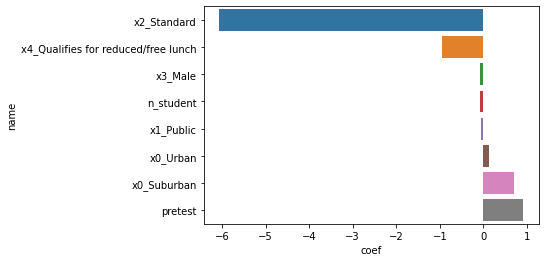

In [184]:
sns.barplot(x='coef', y='name', data=df_coef.sort_values(by='coef'));

# V. Result, Conclusion, and Recommendation

From the linear equation with R2 94% and RMSE 3.2, we are confident in saying that:
- The base post-test score is 22.51
- It increases by 0.69 if the school setting is in the `Suburban` area and by 0.119 if in the `Urban` area
- The score decreased by 0.05 if the school is a `public school`
- `Standard` teaching method decreases the score by 6.06
- If the student is `Male`, the score decreases by 0.08
- If the student `qualifies for reduced/free lunch`, it further decreases by 0.955
- A one-student increase in the `n_student` in the classroom also decreases the score by 0.07
- Higher `pretest` score also means higher posttest score, in that for every 1 score increase in pretest, the student will have 0.91 increase in posttest.

From the equation, we can see that `teaching_method` affects the post-test scores the most, the the next most influential aspect is is the students `qualify for free lunch`. This aspect represents the students' economic background, meaning that students from lower economic ability usually have lower test scores.

From this result, we can implement certain things to improve and balance students' learning ability (as shown by the post-test score). For example, implementing more experimental teaching methods in all schools, finding out the reasons why students from lower economic background have more trouble studying and improving that aspect, building more schools in the suburban area, and decreasing the number of students in a class.